In [18]:
import torch
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATH = r"..\data\Training_Pdrop"
torch.manual_seed(42)

# Load Train Data
print("Load data")
data_files = ["P", "P", "CO", "CO2", "H2", "CH4", "CH3OH", "H2O", "N2"]
States = [pd.read_csv(f"{PATH}\{file}.csv", header=None) for file in data_files]
print("Train Data loaded")

Load data
Train Data loaded


In [55]:
NUMBER_OF_POINTS = 8
states = [state.to_numpy() for state in States]
df_raw = np.stack(states)
mean = df_raw.mean(axis=(1,2), keepdims=True)
std = df_raw.std(axis=(1,2), keepdims=True)

#df = ((df_raw - mean) / std).astype(np.float32)
df = df_raw
min = df.min(axis=(1,2), keepdims=True)
max = df.max(axis=(1,2), keepdims=True)
print(df.shape, max.shape)
df = ((df - min) / (max - min)).astype(np.float32) #range 0 to 1
#df = df_raw.astype(np.float32)

print(df.shape)
df = torch.from_numpy(df).permute(1, 2, 0)[:, :NUMBER_OF_POINTS, ...]
print(df.shape)
input_dim = df.shape[-1]


(9, 5000, 800) (9, 1, 1)
(9, 5000, 800)
torch.Size([5000, 8, 9])


In [40]:
print(data_files)
print("Upper bounds: ", max[:,0,0].tolist())
print("Lower bounds: ", min[:,0,0].tolist())

['T', 'P', 'CO', 'CO2', 'H2', 'CH4', 'CH3OH', 'H2O', 'N2']
Upper bounds:  [569.952065200784, 71.49265445971363, 0.0534738227626869, 0.0839279358015094, 0.4739118921128102, 0.1961240582176027, 0.043617617295987, 0.0166983631358979, 0.0286116689671041]
Lower bounds:  [466.35539818346194, 57.31174829828023, 0.0172916368293674, 0.0552752589680291, 0.3095623691919211, 0.1604881777757451, 0.0028584153155807, 0.0006125105511711, 0.0234112567627298]


In [63]:
print(df_raw.shape)
df_raw2 = np.transpose(df_raw,(1, 2, 0))[:, :NUMBER_OF_POINTS, ...]
print(df_raw2.shape)
print("                ", data_files)

print("sample enc input", list(df_raw2[444,0, :]))
print("sample dec output", df_raw2[440, :, :])

(9, 5000, 800)
(5000, 8, 9)
                 ['T', 'P', 'CO', 'CO2', 'H2', 'CH4', 'CH3OH', 'H2O', 'N2']
sample enc input [509.6634891767956, 64.21623862058296, 0.0399364819697806, 0.0766080670882077, 0.3901792052712248, 0.1744754753168476, 0.0033989528410583, 0.0006347082807082, 0.025494621375979]
sample dec output [[5.48633598e+02 5.97371620e+01 4.24358443e-02 8.14245720e-02
  4.14826246e-01 1.85791150e-01 3.24551249e-03 6.98902145e-04
  2.50397343e-02]
 [5.46266170e+02 5.97356929e+01 4.61772399e-02 7.58588024e-02
  4.05611728e-01 1.85791150e-01 5.06988653e-03 6.26467182e-03
  2.50397343e-02]
 [5.45294561e+02 5.97342324e+01 4.74391764e-02 7.38124892e-02
  4.01996661e-01 1.85791150e-01 5.85426322e-03 8.31098500e-03
  2.50397343e-02]
 [5.44898976e+02 5.97327762e+01 4.79289420e-02 7.27599744e-02
  3.99818648e-01 1.85791150e-01 6.41701242e-03 9.36349977e-03
  2.50397343e-02]
 [5.44780349e+02 5.97313225e+01 4.80535929e-02 7.21727189e-02
  3.98306183e-01 1.85791150e-01 6.87961703e-03 9.9507

In [5]:
# define positional encoding
# def positional_encoding(T, d_model):
#     # Initialize positional encoding matrix
#     t= np.linspace(0, 1, num=T)
#     pe = np.zeros((t.shape[0], d_model))
    
#     # Compute positional encodings
#     for pos, time in enumerate(t):
#         for i in range(d_model):
#             if i % 2 == 0:
#                 pe[pos, i] = np.sin(time / (10000 ** (2 * i / d_model)))
#             else:
#                 pe[pos, i] = np.cos(time / (10000 ** (2 * (i-1) / d_model)))
    
#     return np.array(pe)



# ## Save data
# ID = []
# PE = []
# d_model  = 1
# N = 10

# for i in range(N):
#     PE += [positional_encoding(T-1, d_model)[:,d_model-1]]

# PE = np.array(PE)
# print(PE)
# PE= PE.flatten()
# print(PE.shape)

In [6]:
print(df[0, :,1])
print(df[0, 0,1])
print(df[0, :,1])

print(df[:, 0,:].unsqueeze(1).shape, df[:, :,:].shape)
print( df[:,0,:].unsqueeze(1).repeat(1,3,1).shape)

tensor([0.1710, 0.1709, 0.1708, 0.1707, 0.1706, 0.1705, 0.1704, 0.1703])
tensor(0.1710)
tensor([0.1710, 0.1709, 0.1708, 0.1707, 0.1706, 0.1705, 0.1704, 0.1703])
torch.Size([5000, 1, 9]) torch.Size([5000, 8, 9])
torch.Size([5000, 3, 9])


In [7]:
from torch.utils.data import TensorDataset, DataLoader, random_split
src = df[:,0,:].unsqueeze(1).repeat(1,3,1)
tgt = df[:, :,:]
dataset = TensorDataset(src, tgt) # src inital condition, then prediction the entire sequence

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 24
train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [11]:
class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 20):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        e_count = 0
        o_count = 0
        for d in range(d_model):
            if d%2 == 0:
                pe[:, 0, d] = torch.sin(position * div_term)[:, e_count]
                e_count += 1
            
            else:
                pe[:, 0, d] = torch.cos(position * div_term)[:, o_count]
                o_count += 1
        pe = pe.permute(1,0,2)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        # print(x.shape, self.pe.shape)
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [12]:
class TransformerModel(torch.nn.Module):
     def __init__(self, input_dim, output_dim, d_model=64, nhead=2, num_encoder_layers=2, num_decoder_layers=2, mask_size=1, max_len=5000):
         super(TransformerModel, self).__init__()
         self.model_type = 'Transformer'
         self.linear1 = torch.nn.Linear(input_dim, d_model)
         self.transformer = torch.nn.Transformer(d_model=d_model, nhead=nhead,
                                           num_encoder_layers=num_encoder_layers,
                                           num_decoder_layers=num_decoder_layers, batch_first=True)
         self.linear2 = torch.nn.Linear(d_model, output_dim)
         self.mask_size = mask_size
         self.pe = PositionalEncoding(d_model, max_len=max_len)

     def forward(self, src, tgt, sequence_size=None):
         src = self.linear1(src)
         tgt = self.linear1(tgt)
        
         src = self.pe(src)
         tgt = self.pe(tgt)

         tgt_mask = torch.triu(torch.ones((sequence_size, sequence_size)) == 1).transpose(0, 1)
         tgt_mask = tgt_mask.float().masked_fill(tgt_mask == 0, float('-inf')).masked_fill(tgt_mask == 1, float(0.0))
         
         #tgt_mask = self.transformer.generate_square_subsequent_mask(sequence_size)
         output = self.transformer(src, tgt, tgt_mask=tgt_mask)
         output = self.linear2(output)
         return output


# Instantiate the model
output_dim = input_dim  
d_model = 60
pred_len = NUMBER_OF_POINTS 
sequence_size = NUMBER_OF_POINTS
model = TransformerModel(input_dim, output_dim, d_model=d_model, nhead=4, num_encoder_layers=2, num_decoder_layers=2, max_len=8).to(device)

# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=10e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)
    


In [13]:
# Training loop
num_epochs = 3000
train_outputs = []
train_expected =[]
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(inputs, targets, sequence_size)
        loss = criterion(output, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        train_outputs += output
        train_expected += targets
    
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

    # Early stopping if the loss is low enough
    if avg_loss <= 0.0001:
        print("Training stopped early, loss is below 0.0001.")
        break


Epoch 1/3000, Loss: 0.0676
Epoch 2/3000, Loss: 0.0483
Epoch 3/3000, Loss: 0.0365
Epoch 4/3000, Loss: 0.0171
Epoch 5/3000, Loss: 0.0129
Epoch 6/3000, Loss: 0.0120
Epoch 7/3000, Loss: 0.0117
Epoch 8/3000, Loss: 0.0115
Epoch 9/3000, Loss: 0.0115
Epoch 10/3000, Loss: 0.0116
Epoch 11/3000, Loss: 0.0115
Epoch 12/3000, Loss: 0.0115
Epoch 13/3000, Loss: 0.0115
Epoch 14/3000, Loss: 0.0115
Epoch 15/3000, Loss: 0.0115
Epoch 16/3000, Loss: 0.0116
Epoch 17/3000, Loss: 0.0115
Epoch 18/3000, Loss: 0.0115
Epoch 19/3000, Loss: 0.0116
Epoch 20/3000, Loss: 0.0115
Epoch 21/3000, Loss: 0.0115
Epoch 22/3000, Loss: 0.0116
Epoch 23/3000, Loss: 0.0115
Epoch 24/3000, Loss: 0.0115
Epoch 25/3000, Loss: 0.0115
Epoch 26/3000, Loss: 0.0115
Epoch 27/3000, Loss: 0.0115
Epoch 28/3000, Loss: 0.0116
Epoch 29/3000, Loss: 0.0115
Epoch 30/3000, Loss: 0.0115
Epoch 31/3000, Loss: 0.0115
Epoch 32/3000, Loss: 0.0114
Epoch 33/3000, Loss: 0.0114
Epoch 34/3000, Loss: 0.0115
Epoch 35/3000, Loss: 0.0114
Epoch 36/3000, Loss: 0.0115
E

KeyboardInterrupt: 

In [14]:

# #save model
model_path = ".\\R_pytorch_model.pt"
torch.save(model.state_dict(), model_path)

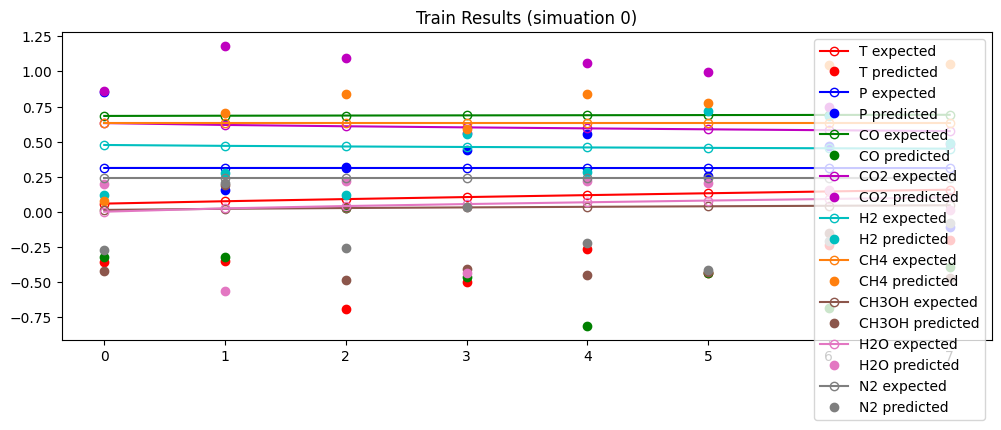

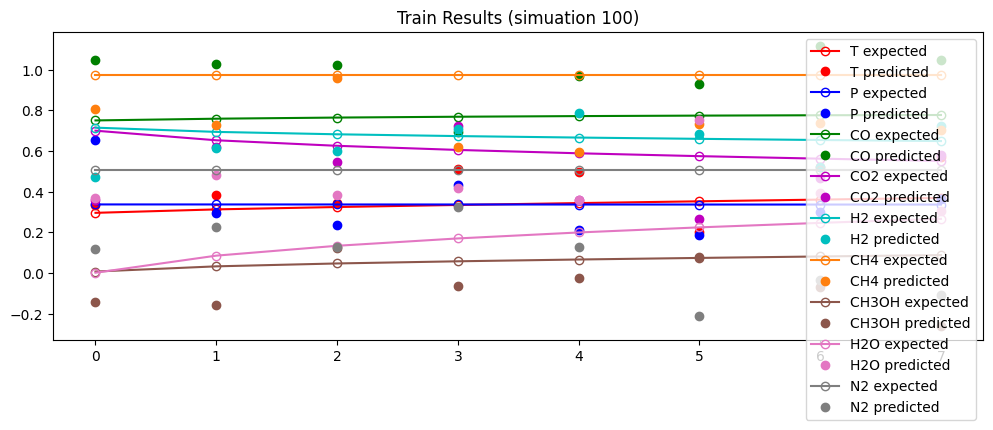

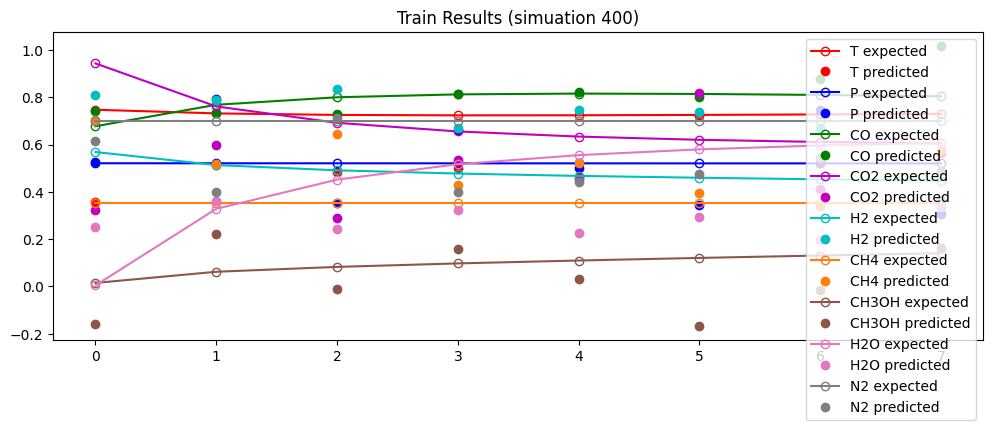

In [15]:
# display train results
import matplotlib.pyplot as plt

colours = ["r", "b", "g", "m", "c", "tab:orange", "tab:brown", "tab:pink", "tab:gray"]
for i in [0, 100, 400]: # select batches
    for d, name in enumerate(data_files):
    
        plt.figure(i, figsize=(12, 4))
        plt.plot(range(sequence_size), train_expected[i][:,d].detach().numpy(), "-o",fillstyle="none", color=colours[d], label=f'{name} expected')
        plt.plot(range(sequence_size), train_outputs[i][:,d].detach().numpy() , "o", color=colours[d], label=f'{name} predicted')
        
        plt.title(f"Train Results (simuation {i})")
        plt.legend()

In [ ]:
# Evaluate the model
model.eval()
outputs = []
expected = []
avg_loss = 0 
with torch.no_grad():
    for inputs, targets in val_loader:
        
        tgt = inputs
        for i in range(sequence_size):
            output = model(inputs, tgt, tgt.shape[1])
            tgt = torch.cat([tgt, output[:, -1:, :]], dim=1)

        outputs += output
        expected += targets
        test_loss = criterion(output, targets)
        avg_loss += test_loss.item()
        #print(f'Test MSE Loss: {test_loss.item():.4f}')

print("Average Loss: ", avg_loss/len(outputs))


In [1]:
# display test results
import matplotlib.pyplot as plt

colours = ["r", "b", "g", "c", "m", "tab:orange", "tab:brown", "tab:pink", "tab:gray"]
for i in [0, 100, 400]: # select batches
    for d, name in enumerate(data_files):
    
        plt.figure(i, figsize=(12, 4))
        plt.plot(range(sequence_size), expected[i][:,d].detach().numpy(), "-o",fillstyle="none", color=colours[d], label=f'{name} expected')
        plt.plot(range(sequence_size), outputs[i][:,d].detach().numpy() , "o", color=colours[d], label=f'{name} predicted')
        
        plt.title(f"Train Results (simuation {i})")
        plt.legend()

NameError: name 'data_files' is not defined

In [ ]:
from torchinfo import summary

print(summary(model, input_data=(X_test, X_test, sequence_size)))